In [1]:

#***********************************************************#
#                >> IN THE NAME OF ALLAH <<                 #
#            Rebar Diameter Optimization Based on           #
#  Moment-Curvature Analysis of Unconfined Concrete Section #
#                  With Axial Load Effect                   #
#-----------------------------------------------------------#
#     This program is written by Salar Delavar Qashqai      #  
#          E-mail:salar.d.ghashghaei@gmail.com              #
#-----------------------------------------------------------#
#Unit: Newton-Milimeter                                     #
#Given:Section Properties , Concrete properties ,           #
# Reinforcing steel properties                              #
#Calculate: Moment-Curavture                                #
# Note: No limit for accounting plurality steel rebar       #
# Newton-Raphson Method : Tangent procedure                 #
#***********************************************************#
#   _    ______________________________________             #
#   |   |                                      |            #
#       |     #     #     #     #    #    #    |            #
#       |     #                           #    |            #
#   b   |    As1   As2   As3   As4  As5  As6   |            #
#       |     #                           #    |            #
#   |   |     #     #     #     #    #    #    |            #
#   _   |______________________________________|            #
#       |<-                 h                ->|            #
#       |<-d1->|                                            #
#       |<-  d2   ->|                                       #
#       |<-     d3      ->|                                 #
#       |<-        d4          ->|                          #
#       |<-            d5          ->|                      #
#       |<-               d6             >|                 #
#    X                                                      #
#    ^                                                      #
#    |             (Moment - Curvature along X axis)        #
#    |                                                      #
#    +----> Y                                               #
#***********************************************************#

In [2]:
def AXIAL_LOAD_ANALYSIS(Ptarget,As, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance):
    An = len(As)
    R=(1/N)
    c=np.array([(.5*R+R*(k-1))*h for k in range(1,N+1)])
    fsi = np.zeros(An)
    fstani = np.zeros(An)
    Cci = np.zeros(N)
    Cctani = np.zeros(N)
    Fsi = np.zeros(An)
    Fstani = np.zeros(An)
    if abs(Ptarget) > 0:
        it = 0 # initialize iteration count
        residual = 100 # initialize residual
        eci = 1e-12 
        while residual > tolerance:
                for u in range(An):
                    # As
                    if eci > 0 and eci < ey:
                        fsi[u] = Es * eci
                        fstani[u] = Es
                    elif eci < 0 and eci > -ey:
                        fsi[u] = Es * eci
                        fstani[u] = -Es
                    elif eci >= ey and eci < esh:
                        fsi[u] = fy
                        fstani[u] = 0
                    elif eci <= -ey and eci > -esh:
                        fsi[u] = -fy
                        fstani[u] = 0
                    elif eci >= esh and eci < esu:
                        fsi[u] = fy + Esh * (abs(eci) - esh)
                        fstani[u] = Esh
                    elif eci <= -esh and eci > -esu:
                        fsi[u] = -fy - Esh * (abs(eci) - esh)
                        fstani[u] = -Esh
                    elif eci >= esu or eci <= -esu:
                        fsi[u] = 0
                        fstani[u] = 0

                    Fsi[u] = As[u] * fsi[u]
                    Fstani[u] = As[u] * fstani[u] # tangent steel force

                if eci > 0 and eci < ec0: # in this step: Unconfined concrete force in rebar area is omitted (F=As*fc
                        for z in range(N):  # in this step: concrete force for each fiber is calculated
                            # -------------- Cc --------------%
                            if eci > 0 and eci < ec0:
                                Ci = fc * ((2 * eci / ec0) - (eci / ec0) ** 2)
                                Ctani = fc * ((2 / ec0) - ((2 * eci) / ec0 ** 2))
                            elif eci >= ec0 and eci < ecu:
                                Ci = fc * (1 - (0.15 * (eci - ec0) / (ecu - ec0)))
                                Ctani = -3 * fc / (20 * (ecu - ec0))
                            elif eci >= ecu:
                                Ci = 0
                                Ctani = 0
                            elif eci < 0 and eci >= ect1:
                                Ci = 0.5 * Ec * eci
                                Ctani = 0.5 * Ec
                            elif eci < ect1 and eci >= ect2:
                                Ci = fct - (0.5 * fct / (ect2 - ect1)) * (eci - ect1)
                                Ctani = -(0.5 * fct / (ect2 - ect1))
                            elif eci < ect2 and eci >= ect3:
                                Ci = .5 * fct - (0.5 * fct / (ect3 - ect2)) * (eci - ect2)
                                Ctani = -(0.5 * fct / (ect3 - ect2))
                            elif eci < ect3:
                                Ci = 0
                                Ctani = 0

                            Cci[z] = b * R * h * Ci
                            Cctani[z] = b * R * h * Ctani  # tangent concrete force

                # ----------------------------------%
                FsTOTAL = sum(Fsi)
                CcTOTAL = sum(Cci)
                Ai = CcTOTAL + FsTOTAL - Ptarget
                FsTOTAL_tan = sum(Fstani)
                CcTOTAL_tan = sum(Cctani)
                A_tani = CcTOTAL_tan + FsTOTAL_tan
                dxi = (-Ai) / A_tani
                residual = abs(dxi)  # evaluate residual
                it += 1  # increment iteration count
                eci += dxi  # update x
                if it == itermax:  # stop the analysis of this step please of Convergence
                    print(f'(-) trail iteration reached to Ultimate {it} - strain: {eci:.6f} - error: [{residual:.2f}]')
                    print(' ## The solution for this step is not converged. Please check your model ##')

                if residual < tolerance:  # iteration control
                    print(f'(+)Axial Load effect: It is converged in {it} iterations - Initial axial strain: {eci:.6f}\n\n')
                    break
                else:
                    eci = 0
    return eci    


In [3]:
def MOMENT_CURVATURE_ANALYSIS(ECI, Ptarget, As, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance, x):
    # Newton Method Procedure
    An = len(As)
    R=(1/N)
    c=np.array([(.5*R+R*(k-1))*h for k in range(1,N+1)])
    EC=np.array([.1*abs(ect1), .2*abs(ect1), .4*abs(ect1), .6*abs(ect1), .8*abs(ect1), abs(ect1), abs(ect2), .33*abs(ect3), .67*abs(ect3), .8*abs(ect3), .9*abs(ect3), abs(ect3), .4*ecu, .5*ecu, .6*ecu, .7*ecu, .8*ecu, .9*ecu, ecu])
    q=len(EC)
    fs = np.zeros(An)
    fstan = np.zeros(An)
    CS = np.zeros(An)
    CD = np.zeros(N)
    Cc = np.zeros(N)
    Cctan = np.zeros(N)
    CtanS = np.zeros(N)
    Fss = np.zeros(An)
    Fstans = np.zeros(An)
    TSCSs = np.zeros(q)
    BSCSs = np.zeros(q)
    TSCS = np.zeros(q)
    BSCS = np.zeros(q)
    ECCC = np.zeros(q)
    TUCS = np.zeros(q)
    Cur = np.zeros(q)
    Mom = np.zeros(q)
    CUR = np.zeros(q)
    XX = np.zeros(q)
    CrackDepth = np.zeros(q)
    print('======================================================================================== ')
    print('   Increment      Iterations      Strain      Neutral-Axis      Curvature      Moment    ')
    print('======================================================================================== ')
    for j in range(q):
        eC = ECI + EC[j]
        it = 0 # initialize iteration count
        residual = 100 # initialize residual
        while (residual > tolerance):
            for u in range(An):
                es = eC * (x - d[u]) / x
                # As
                if es > 0 and es < ey:
                    fs[u] = Es * es
                    fstan[u] = (Es * eC * d[u]) / (x ** 2)
                elif es < 0 and es > -ey:
                    fs[u] = Es * es
                    fstan[u] = (Es * eC * d[u]) / (x ** 2)
                elif es >= ey and es < esh:
                    fs[u] = fy
                    fstan[u] = 0
                elif es <= -ey and es > -esh:
                    fs[u] = -fy
                    fstan[u] = 0
                elif es >= esh and es < esu:
                    fs[u] = fy + Esh * (abs(es) - esh)
                    fstan[u] = (Esh * eC * d[u]) / (x ** 2)
                elif es <= -esh and es > -esu:
                    fs[u] = -fy - Esh * (abs(es) - esh)
                    fstan[u] = (Esh * eC * d[u]) / (x ** 2)
                elif es >= esu or es <= -esu:
                    fs[u] = 0
                    fstan[u] = 0
                Fs = As * fs
                Fstan = As * fstan # tangent steel force
                if es > 0 and es < ec0: # in this step: Unconfined concrete force in rebar area is omitted (F=As*fc)
                    Cs = fc * ((2 * es / ec0) - (es / ec0) ** 2)
                    Ctans = ((2 * fc) / (ec0 ** 2 * x ** 3)) * (ec0 * eC * d[u] * x - d[u] * eC ** 2 * x + 2 * eC ** 2 * d[u] ** 2)
                elif es >= ec0 and es <= ecu:
                    Cs = fc * (1 - (0.15 * (es - ec0) / (ecu - ec0)))
                    Ctans = -(3 * eC * d[u] * fc) / (20 * (ecu - ec0) * x ** 2)
                elif es > ecu:
                    Cs = 0
                    Ctans = 0
                elif es < 0 and es >= ect1:
                    Cs = -0.5 * Ec * es
                    Ctans = -(0.5 * Ec * d[u] * eC) / x ** 2
                elif es < ect1 and es >= ect2:
                    Cs = fct + (0.5 * fct / (ect2 - ect1)) * (es - ect1)
                    Ctans = +(0.5 * fct * eC * d[u]) / ((ect2 - ect1) * x ** 2)
                elif es < ect2 and es >= ect3:
                    Cs = -( .5*fct-(0.5*fct/(ect3-ect2))*(es-ect2))
                    Ctans = +(0.5*fct*eC*d[u])/((ect3-ect2)*x**2)
                elif es < ect3:
                    Cs = 0
                    Ctans = 0

                CS[u] = Cs
                CtanS[u] = Ctans
                Fss[u] = -As[u] * CS[u]
                Fstans[u] = -As[u] * CtanS[u] # tangent Minus of concrete force  
            for z in range(N): # in this step: concrete force for each fiber is calculated  
                ec = eC * (x - c[z]) / x
                CD = np.zeros(N)
                if ec > 0 and ec < ec0:
                    C = fc * ((2 * ec / ec0) - (ec / ec0) ** 2)
                    Ctan = ((2 * fc) / (ec0 ** 2 * x ** 3)) * (ec0 * eC * c[z] * x - c[z] * eC ** 2 * x + 2 * eC ** 2 * c[z] ** 2)
                    CD[z] = 0
                elif ec >= ec0 and ec <= ecu:
                    C = fc * (1 - (0.15 * (ec - ec0) / (ecu - ec0)))
                    Ctan = -(3 * eC * c[z] * fc) / (20 * (ecu - ec0) * x ** 2)
                    CD[z] = 0
                elif ec > ecu:
                    C = 0
                    Ctan = 0
                    CD[z] = 0
                elif ec < 0 and ec >= ect1:
                    C = 0.5 * Ec * ec
                    Ctan = (0.5 * Ec * c[z] * eC) / x ** 2
                    CD[z] = 0
                elif ec < ect1 and ec >= ect2:
                    C = fct - (0.5 * fct / (ect2 - ect1)) * (ec - ect1)
                    Ctan = -(0.5 * fct * eC * c[z]) / ((ect2 - ect1) * x ** 2)
                    CD[z] = 0
                elif ec < ect2 and ec >= ect3:
                    C = .5*fct-(0.5*fct/(ect3-ect2))*(ec-ect2)
                    Ctan=-(0.5*fct*eC*c[z])/((ect3-ect2)*x**2)
                    CD[z]=0
                elif ec < ect3:
                    C = 0
                    Ctan = 0
                    CD[z] = h - c[z] # Crack Depth

                Cc[z] = b*R*h*C
                Cctan[z] = b*R*h*Ctan # tangent concrete force

            FsTOTAL = sum(Fs)
            CcTOTAL = sum(Cc)
            FssTOTAL = sum(Fss)
            A = CcTOTAL + FsTOTAL - Ptarget
            FsTOTAL_tan = sum(Fstan)
            CcTOTAL_tan = sum(Cctan)
            A_tan = CcTOTAL_tan + FsTOTAL_tan
            dx = A_tan ** -1 * (-A)
            residual = np.max(np.abs(dx)) # evaluate residual
            it += 1 # increment iteration count
            x += dx # update x
            if it == itermax: # stop the the analysis of this step please of Convergence
                print(f'      {j+1}             {it} : trail iteration reached to Ultimate - strain: {eC:.6f} - error: [{A:.2f}]')
                print('    ## The solution for this step is not converged. Please check your model ##')
                break

            if it == itermax:
                break # stop the analysis at all because last Convergence

            e = x - d # distance of each rebar from Neuteral axis
            cc = x - c # distance of each concrete fiber from Neuteral axis
            Pc1 = x - .5 * h# distance of Axial Load from Neuteral axis

        if residual < tolerance: # iteration control
            print(f'      {j+1}             {it}            {eC:.6f}           {x:.2f}      {(eC/x)*1000:.5f}         {(np.dot(Fs,e)+np.dot(Fss,e)+np.dot(Cc,cc))*10**-6:.2f}')

            TSCSs[j] = eC * (x - d[0]) / x; TSCS[j] = fs[0] # Top Steel compression strain-stress
            BSCSs[j] = eC * (x - d[5]) / x; BSCS[j] = fs[5] # Bottom Steel compression strain-stress

            if eC > 0 and eC < ec0:
                ECCC[j] = eC; TUCS[j] = fc * ((2 * eC / ec0) - (eC / ec0) ** 2)# Concrete Strain-Stress
            elif eC >= ec0 and eC <= ecu:
                ECCC[j] = eC; TUCS[j] = fc * (1 - (0.15 * (eC - ec0) / (ecu - ec0)))# Concrete Strain-Stress

            if CD[z] == 0:
                CrackDepth[j] = 0
            else:
                CrackDepth[j] = max(abs(CD)) # Crack Depth of each increment

            # Calculate Moment and Curavture
            Cur[j] = (eC / x) * 1000;CUR[j] = Cur[j];XX[j] = x;
            Mom[j] = (np.dot(Fs,e) + np.dot(Fss,e) + np.dot(Cc,cc) + Pc1 * Ptarget) * 10 ** -6
            #Mom[j] = (Fs * e + Fss * e + Cc * cc + Pc1 * Ptarget) * 10 ** -6

    Cur = np.insert(Cur, 0, 0)
    Mom = np.insert(Mom, 0, 0)
    s = len(Cur)
    EI = np.zeros(s-1)
    for i in range(s-1):
        EI[i] = (Mom[i+1] - Mom[i]) / (Cur[i+1] - Cur[i]) # Flextural Rigidity

    if round(eC, 5) == ecu:
        print(f'\n      ## Unconfined Concrete Strain Reached to Ultimate Strain: {eC:.4f} ## \n\n')
    return CrackDepth, EC, XX, CUR, EI, Cur, Mom, TSCSs, TSCS, BSCSs, BSCS, ECCC, TUCS  

In [6]:
def BILNEAR_CURVE(Cur, Mom):
# UnConfined bilinear fitting
    SIZE = len(Mom)
    hh = np.zeros(SIZE-1)
    Aa = np.zeros(SIZE-1)
    for i in range(SIZE-1):
        hh[i] = Cur[i+1] - Cur[i]
        Aa[i] = (Mom[i] + Mom[i+1]) * 0.5 * hh[i]

    Area = sum(Aa)
    k0 = Mom[4] / Cur[4]
    fiy = (Mom[i+1] * max(Cur) * 0.5 - Area) / (Mom[i+1] * 0.5 - k0 * max(Cur) * 0.5)
    My = k0 * fiy
    X = np.array([0, fiy, max(Cur)])
    Y = np.array([0, My, Mom[i+1]])

    print('+==========================+')
    print('=   Analysis curve fitted =')
    print('  Curvature    Moment')
    print('----------------------------')
    print(np.column_stack((X.T, Y.T)))
    print('+==========================+')

    # EI and Ductility_Rito of Unconfined Section
    Elastic_EI = Y[1] / X[1]
    Plastic_EI = (Y[2] - Y[1]) / (X[2] - X[1])
    Ductility_Rito = X[2] / X[1]
    Over_Strength_Factor = Y[2] / Y[1]
    print('+--------------------------------------------------------------------+')
    print(f' Elastic Flextural Rigidity :             {Elastic_EI:.4f} ')
    print(f' Plastic Flextural Rigidity :             {Plastic_EI:.4f} ')
    print(f' Unconfined Section Ductility Ratio :     {Ductility_Rito:.4f}')
    print(f' Unconfined Section Over Strength Factor: {Over_Strength_Factor:.4f}')
    print('+--------------------------------------------------------------------+')
    return X, Y, Elastic_EI, Plastic_EI, Ductility_Rito, Over_Strength_Factor



In [7]:
def OUTPUT_EXCEL(EC, center, Cur, Mom, EI):
    with open(ShowText, "w") as OutputFile:
        OutputFile.write("    ### Output Concrete Section Moment Curvature Analysis With Axial Load effect    ###\n")
        OutputFile.write("Increment,Strain,Neuteral Axis,Curvature,Moment,Flextural Rigidity-EI\n")
        for i in range(len(EC)):
            OutputFile.write("%d,%e,%e,%e,%e,%e\n" % (i + 1, EC[i], center[i], Cur[i], Mom[i], EI[i]))

In [8]:
## TARGET IS OPTIMUM REBAR DIAMETER BASED ON DUCTILITY RATIO

import os
os.system('cls' if os.name == 'nt' else 'clear')
import numpy as np
import time
# Input Datas
Ptarget = 1 # [N] Target axial load [+ : Compression]
b = 500 # [mm]
h = 500 # [mm]
# d:d1 d2 d3 d4 d5 d6
d = np.array([50, 0, 0, 0, 0, 450])
# Concrete Properties
fc = 25 # [N/mm^2] Unconfined concrete strength
ecu = 0.004 # Ultimate concrete strain
Ec = 5000 * np.sqrt(fc)
ec0 = (2 * fc) / Ec
fct = -0.7 * np.sqrt(fc) # Concrete tension stress
ect1 = (2 * fct) / Ec; ect2 = (2.625 * fct) / Ec; ect3 = (9.292 * fct) / Ec # Concrete tension strain
# Reinforcing steel Properties
fy = 400 # [N/mm^2] Yield strength of reinforcing steel
Es = 2e5 # [N/mm^2] Modulus of elasticity of steel
fu = 1.5 * fy # Ultimate steel stress
ey = fy / Es # Yield steel strain
esh = 0.01 # Strain at steel strain-hardening
esu = 0.09 # Ultimate steel strain
Esh = (fu - fy) / (esu - esh)
N = 1000 # Number of concrete Fiber
itermax = 10000 # maximum number of iterations
tolerance = 10e-7 # specified tolerance for convergence
x = .5 * h # initial guess of Neuteral axis


DC_RATIO_MIN = 10; # Minimum Ductility Rito
DC_RATIO_MAX = 12; # Maximum Ductility Rito
ESP = 1e-3 # Epsilon ratio
TOLERANCE = 1e-6 # Converage Tolerance ratio

IT = 0 # initialize iteration count
ITERMAX = 100000 # maximum initialize iteration count
RESIDUAL = 100 # initialize residual
RD = 25 # initialize rebar diameter

# monitor cpu time
starttime = time.process_time()

### OPTIMZATION OF REBAR DIAMETER:

while (RESIDUAL > TOLERANCE):
    
        print(f"### Iteration: {IT+1} ###")
        print(f"=========================\n\n")
        
        RDA = 3.1415*(RD**2)/4 # Rebar Area
        # As: As1 As2 As3 As4 As5 As6
        AS = np.array([RDA*5, 0, 0, 0, 0, RDA*5]) # NOTE: As1 & As6 
        ECI = AXIAL_LOAD_ANALYSIS(Ptarget,AS, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance)
        CrackDepth, EC, XX, CUR, EI, Cur, Mom, TSCSs, TSCS, BSCSs, BSCS, ECCC, TUCS = MOMENT_CURVATURE_ANALYSIS(ECI , Ptarget, AS, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance, x)
        X, Y, Elastic_EI, Plastic_EI , Ductility_Rito, Over_Stregth_Factor = BILNEAR_CURVE(Cur, Mom)
        F = Ductility_Rito - DC_RATIO_MAX
        
        # MINIMUN EPSILON
        RD_MIN = RD - ESP # epsilon Rebar Diameter
        RDA_MIN = 3.1415*(RD_MIN**2)/4 # Rebar Area
        # As: As1 As2 As3 As4 As5 As6
        AS_MIN = np.array([RDA_MIN*5, 0, 0, 0, 0, RDA_MIN*5]) # NOTE: As1 & As6 
        ECI = AXIAL_LOAD_ANALYSIS(Ptarget,AS_MIN, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance)
        CrackDepth, EC, XX, CUR, EI, Cur, Mom, TSCSs, TSCS, BSCSs, BSCS, ECCC, TUCS = MOMENT_CURVATURE_ANALYSIS(ECI , Ptarget, AS_MIN, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance, x)
        X, Y, Elastic_EI, Plastic_EI , Ductility_Rito_MIN, Over_Stregth_Factor = BILNEAR_CURVE(Cur, Mom)
        Fmin = Ductility_Rito_MIN - DC_RATIO_MAX

        # MAXIMUN EPSILON
        RD_MAX = RD + ESP # epsilon Rebar Diameter
        RDA_MAX = 3.1415*(RD_MAX**2)/4 # Rebar Area
        # As: As1 As2 As3 As4 As5 As6
        AS_MAX = np.array([RDA_MAX*5, 0, 0, 0, 0, RDA_MAX*5]) # NOTE: As1 & As6
        ECI = AXIAL_LOAD_ANALYSIS(Ptarget,AS_MAX, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance)
        CrackDepth, EC, XX, CUR, EI, Cur, Mom, TSCSs, TSCS, BSCSs, BSCS, ECCC, TUCS = MOMENT_CURVATURE_ANALYSIS(ECI , Ptarget, AS_MAX, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance, x)
        X, Y, Elastic_EI, Plastic_EI , Ductility_Rito_MAX, Over_Stregth_Factor = BILNEAR_CURVE(Cur, Mom)
        Fmax = Ductility_Rito_MAX - DC_RATIO_MAX
        
        #Derivative
        DF = (Fmax - Fmin) / (2 * ESP)

        DX = F / DF
        RESIDUAL = np.max(np.abs(DX)) # evaluate residual
        RD -= DX; # update rebar diameter
        IT += 1; # increment iteration count
        
        if IT == ITERMAX:
            print(f"\n\n\t\t it is no converged - residual: {RESIDUAL:.4f}")
            print("\t\t Change (Epsilon ratio) and (Converage Tolerance ratio)")      
            break # stop the analysis at all because last Convergence
            
        if Ductility_Rito >= Ductility_Rito_MIN and Ductility_Rito <= Ductility_Rito_MAX:
            print(f"\n\n\t\t it is converged in {IT+1} - residual: {RESIDUAL:.4f}")
            print(f"\t\t Optimum Rebar Diameter: {RD:.2f}")
            break # stop the analysis at all because last Convergence

#OUTPUT_EXCEL(EC, XX, Cur, Mom, EI)
totaltime = time.process_time() - starttime
print(f"\n\n\t\t Optimum Rebar Diameter: {RD:.2f}")
print(f'\nTotal time (s): {totaltime:.4f} \n\n')

### Iteration: 1 ###


(+)Axial Load effect: It is converged in 1 iterations - Initial axial strain: 0.000000


   Increment      Iterations      Strain      Neutral-Axis      Curvature      Moment    
      1             5            0.000028           215.12      0.00013         16.91
      2             4            0.000056           215.37      0.00026         33.73
      3             4            0.000112           215.87      0.00052         67.07
      4             5            0.000168           216.37      0.00078         100.02
      5             5            0.000224           216.64      0.00103         132.38
      6             6            0.000280           206.02      0.00136         148.54
      7             7            0.000368           186.41      0.00197         178.59
      8             7            0.000429           176.63      0.00243         198.90
      9             9            0.000872           150.32      0.00580         360.53
      10          

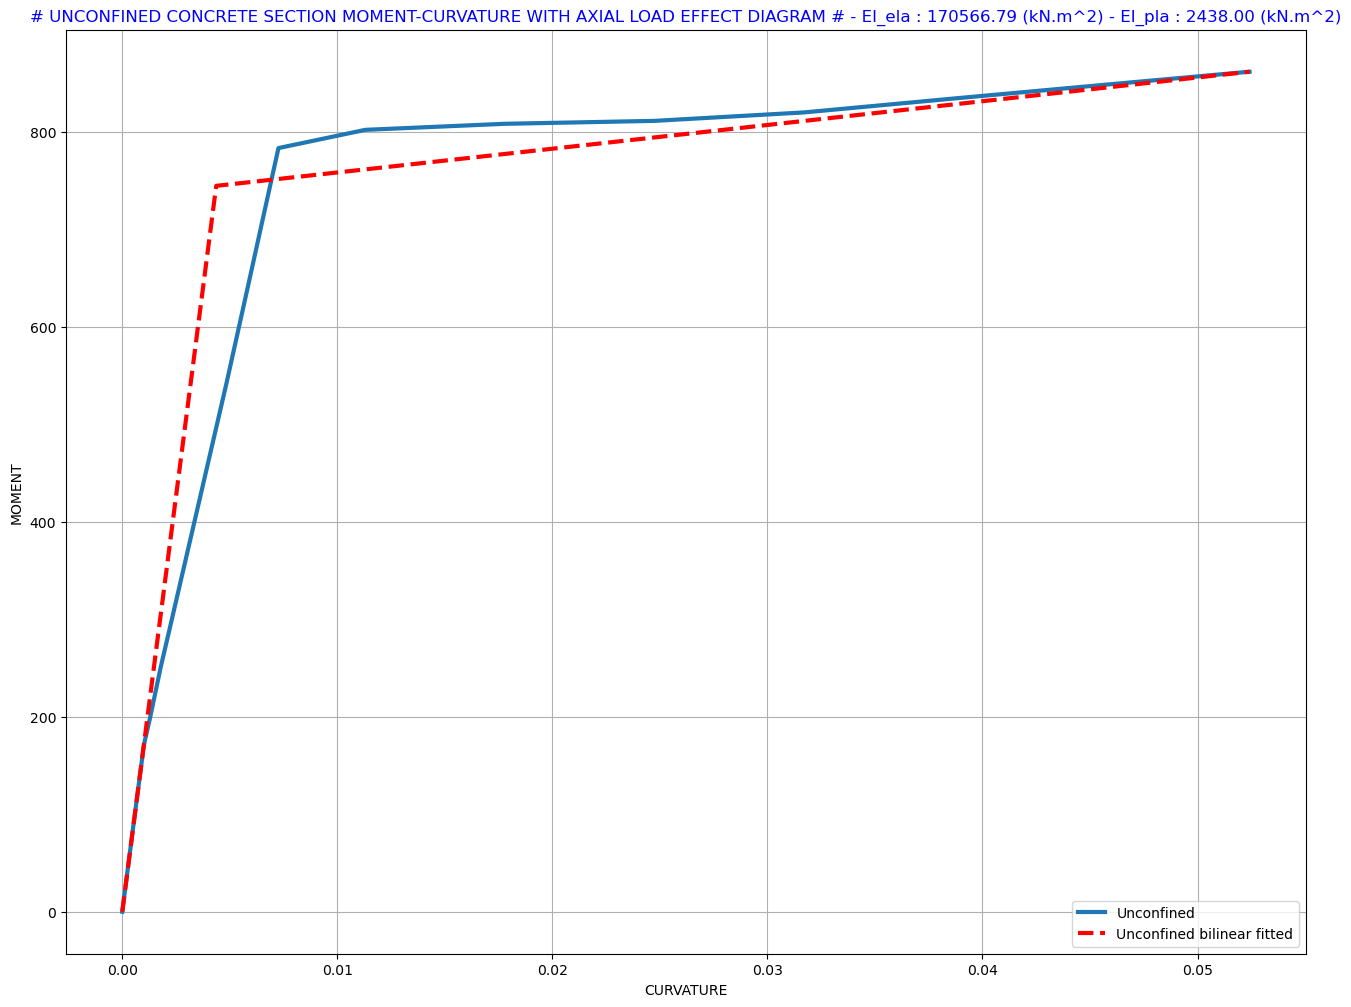

In [9]:
# plot the Moment Curvature Analysis
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
plt.plot(Cur, Mom, X, Y, 'r--', linewidth=3)
plt.title(f'# UNCONFINED CONCRETE SECTION MOMENT-CURVATURE WITH AXIAL LOAD EFFECT DIAGRAM # - EI_ela : {Elastic_EI:.2f} (kN.m^2) - EI_pla : {Plastic_EI:.2f} (kN.m^2)', color='b')
plt.xlabel('CURVATURE')
plt.ylabel('MOMENT')
plt.grid()
plt.legend(['Unconfined', 'Unconfined bilinear fitted'], loc='lower right')

In [12]:
## TARGET IS OPTIMUM REBAR DIAMETER BASED ON OVER STRENGTH FACTOR

os.system('cls' if os.name == 'nt' else 'clear')
OSF_RATIO_MIN = 1.1; # Minimum Over Strength Factor
OSF_RATIO_MAX = 1.2; # Maximum Over Strength Factor
ESP = 1e-3 # Epsilon ratio
TOLERANCE = 1e-6 # Converage Tolerance ratio

IT = 0 # initialize iteration count
ITERMAX = 100000 # maximum initialize iteration count
RESIDUAL = 100 # initialize residual
RD = 25 # initialize rebar diameter

# monitor cpu time
starttime = time.process_time()

### OPTIMZATION OF REBAR DIAMETER:

while (RESIDUAL > TOLERANCE):
    
        print(f"### Iteration: {IT+1} ###")
        print(f"=========================\n\n")
        
        RDA = 3.1415*(RD**2)/4 # Rebar Area
        # As: As1 As2 As3 As4 As5 As6
        AS = np.array([RDA*5, 0, 0, 0, 0, RDA*5]) # NOTE: As1 & As6 
        ECI = AXIAL_LOAD_ANALYSIS(Ptarget,AS, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance)
        CrackDepth, EC, XX, CUR, EI, Cur, Mom, TSCSs, TSCS, BSCSs, BSCS, ECCC, TUCS = MOMENT_CURVATURE_ANALYSIS(ECI , Ptarget, AS, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance, x)
        _, _, _, _ , _, Over_Stregth_Factor = BILNEAR_CURVE(Cur, Mom)
        F = Over_Stregth_Factor - OSF_RATIO_MAX
        
        # MINIMUN EPSILON
        RD_MIN = RD - ESP # epsilon Rebar Diameter
        RDA_MIN = 3.1415*(RD_MIN**2)/4 # Rebar Area
        # As: As1 As2 As3 As4 As5 As6
        AS_MIN = np.array([RDA_MIN*5, 0, 0, 0, 0, RDA_MIN*5]) # NOTE: As1 & As6 
        ECI = AXIAL_LOAD_ANALYSIS(Ptarget,AS_MIN, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance)
        CrackDepth, EC, XX, CUR, EI, Cur, Mom, TSCSs, TSCS, BSCSs, BSCS, ECCC, TUCS = MOMENT_CURVATURE_ANALYSIS(ECI , Ptarget, AS_MIN, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance, x)
        _, _, _, _ , _, Over_Stregth_Factor_MIN = BILNEAR_CURVE(Cur, Mom)
        Fmin = Over_Stregth_Factor_MIN - OSF_RATIO_MAX

        # MAXIMUN EPSILON
        RD_MAX = RD + ESP # epsilon Rebar Diameter
        RDA_MAX = 3.1415*(RD_MAX**2)/4 # Rebar Area
        # As: As1 As2 As3 As4 As5 As6
        AS_MAX = np.array([RDA_MAX*5, 0, 0, 0, 0, RDA_MAX*5]) # NOTE: As1 & As6
        ECI = AXIAL_LOAD_ANALYSIS(Ptarget,AS_MAX, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance)
        CrackDepth, EC, XX, CUR, EI, Cur, Mom, TSCSs, TSCS, BSCSs, BSCS, ECCC, TUCS = MOMENT_CURVATURE_ANALYSIS(ECI , Ptarget, AS_MAX, d, fc ,ecu, Ec, ec0, fct, ect1, fy, Es, fu, ey, esh, esu, Esh, N, itermax, tolerance, x)
        _, _, _, _ , _, Over_Stregth_Factor_MAX = BILNEAR_CURVE(Cur, Mom)
        Fmax = Over_Stregth_Factor_MAX - OSF_RATIO_MAX
        
        #Derivative
        DF = (Fmax - Fmin) / (2 * ESP)

        DX = F / DF
        RESIDUAL = np.max(np.abs(DX)) # evaluate residual
        RD -= DX; # update rebar diameter
        IT += 1; # increment iteration count
        
        if IT == ITERMAX:
            print(f"\n\n\t\t it is no converged - residual: {RESIDUAL:.4f}")
            print("\t\t Change (Epsilon ratio) and (Converage Tolerance ratio)")      
            break # stop the analysis at all because last Convergence
            
        if Over_Stregth_Factor >= Over_Stregth_Factor_MIN and Over_Stregth_Factor <= Over_Stregth_Factor_MAX:
            print(f"\n\n\t\t it is converged in {IT+1} - residual: {RESIDUAL:.4f}")
            print(f"\t\t Optimum Rebar Diameter: {RD:.2f}")
            break # stop the analysis at all because last Convergence

#OUTPUT_EXCEL(EC, XX, Cur, Mom, EI)
totaltime = time.process_time() - starttime
print(f"\n\n\t\t Optimum Rebar Diameter: {RD:.2f}")
print(f'\nTotal time (s): {totaltime:.4f} \n\n')

### Iteration: 1 ###


(+)Axial Load effect: It is converged in 1 iterations - Initial axial strain: 0.000000


   Increment      Iterations      Strain      Neutral-Axis      Curvature      Moment    
      1             5            0.000028           215.12      0.00013         16.91
      2             4            0.000056           215.37      0.00026         33.73
      3             4            0.000112           215.87      0.00052         67.07
      4             5            0.000168           216.37      0.00078         100.02
      5             5            0.000224           216.64      0.00103         132.38
      6             6            0.000280           206.02      0.00136         148.54
      7             7            0.000368           186.41      0.00197         178.59
      8             7            0.000429           176.63      0.00243         198.90
      9             9            0.000872           150.32      0.00580         360.53
      10          

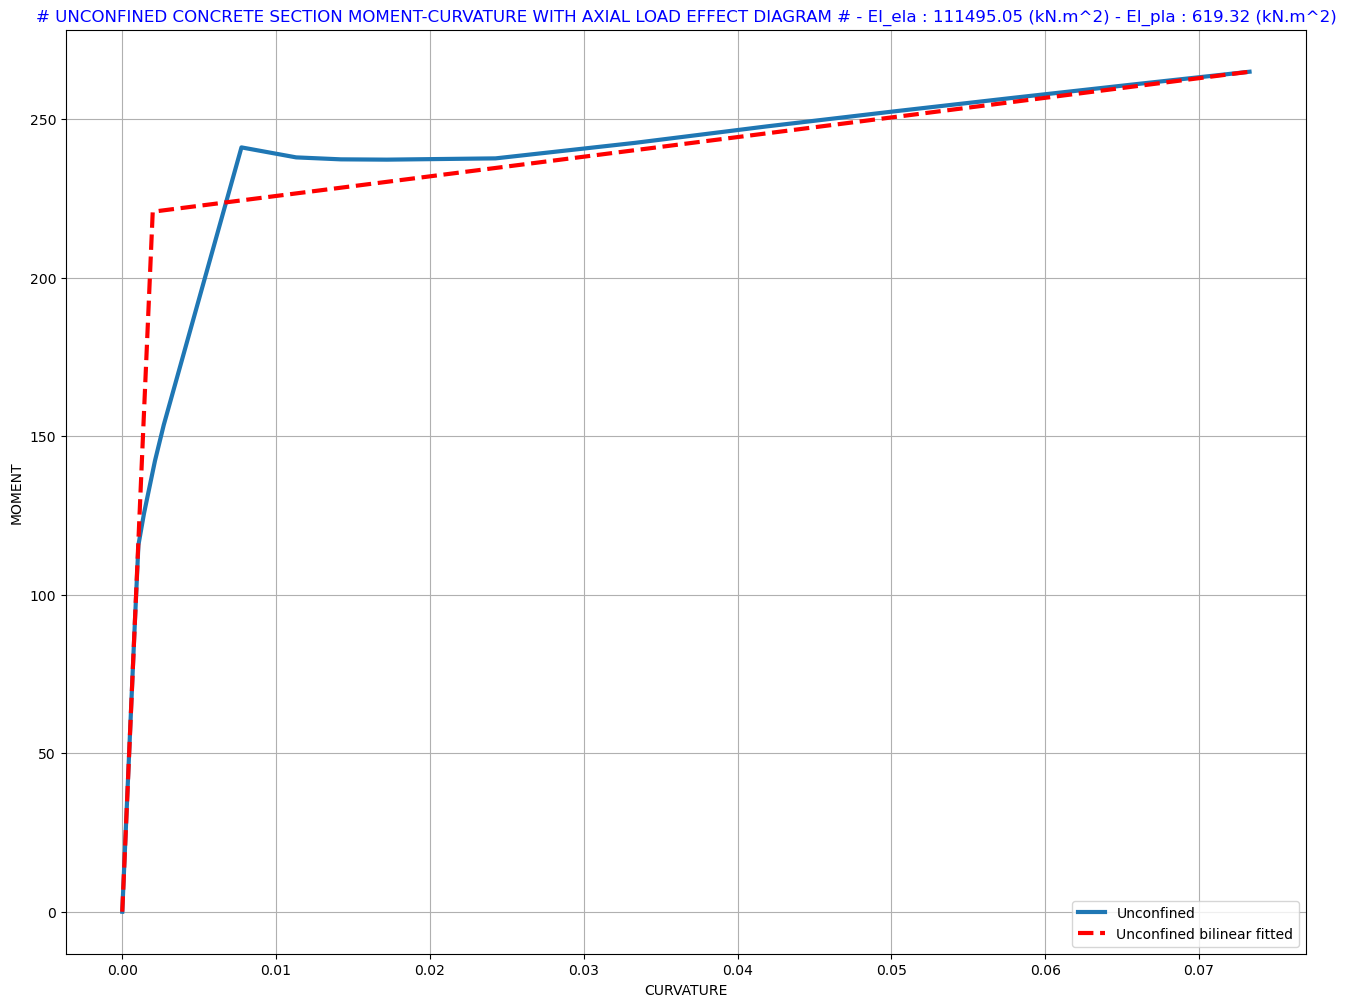

In [13]:
# plot the Moment Curvature Analysis
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
plt.plot(Cur, Mom, X, Y, 'r--', linewidth=3)
plt.title(f'# UNCONFINED CONCRETE SECTION MOMENT-CURVATURE WITH AXIAL LOAD EFFECT DIAGRAM # - EI_ela : {Elastic_EI:.2f} (kN.m^2) - EI_pla : {Plastic_EI:.2f} (kN.m^2)', color='b')
plt.xlabel('CURVATURE')
plt.ylabel('MOMENT')
plt.grid()
plt.legend(['Unconfined', 'Unconfined bilinear fitted'], loc='lower right')